# Import Necessary Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

import json
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import copy

from collections import defaultdict

from models.dynca import DyNCA

from utils.misc.display_utils import plot_train_log, save_train_image
from utils.misc.preprocess_texture import preprocess_style_image
from utils.misc.video_utils import VideoWriter
import matplotlib.pyplot as plt
from utils.misc.flow_viz import flow_to_image, plot_vec_field

from utils.loss.loss import Loss
from IPython.display import clear_output

from utils.load_files import load_compressed_tensor

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
torch.backends.cudnn.deterministic = True

# Load motion vector field

torch.Size([1, 12, 360, 640])
torch.Size([1, 2, 360, 640])
tensor(200684)


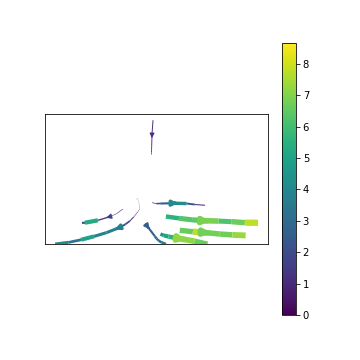

In [2]:
loaded_vector_field = load_compressed_tensor('data/VectorFieldMotion/01007_00000_motion.pth')

update_mask = torch.where(loaded_vector_field[0, 0] * loaded_vector_field[0, 1] == 0 , 0, 1)[None, None, :, :]
update_mask = torch.cat((update_mask, update_mask, update_mask, torch.ones(1, 9, loaded_vector_field.shape[2], loaded_vector_field.shape[3])), 1)
print(update_mask.shape)

print(loaded_vector_field.shape)
test = loaded_vector_field[0, 0] * loaded_vector_field[0, 1]
print(torch.sum(test == 0))
#for some reason, it seems like plot_vec_field only plots the bounding box of the non-zero values of the vector field
target_flow_vector_field = plot_vec_field(loaded_vector_field[0].numpy(), name='Target')
target_flow_vector_field

# Parameter Setting
Use a class to store all parameters in argparse style

In [3]:
class Args:
    def __init__(self):
        # motion loss
        self.img_size = [640, 360] # Controls the image size during training. Corresponds to DyNCA-S/L-img_size in paper
        self.motion_img_size = self.img_size
        self.output_dir = "out/VectorFieldMotion/"
        self.video_length = 10
        self.video_only = False
        self.target_appearance_path = "data/VectorFieldMotion/01007_00000_input.jpg"
        
        """NCA related arguments"""
        self.nca_pool_size = 256
        self.nca_step_range = [32, 128]
        self.nca_inject_seed_step = 8
        self.nca_c_in = 12 # Input channel of DyNCA, DyNCA-S is 12, DyNCA-L is 16
        self.nca_mask = update_mask
        self.nca_fc_dim = 96 # Dimensionality of Update MLP in DyNCA. DyNCA-S is 96, DyNCA-L is 128
        self.nca_seed_mode = "zeros" # Initialize seed with zero-filled tensor
        self.nca_padding_mode = 'replicate' # Replicate padding when performing Perception, as introduced in Section 3.3
        self.nca_pos_emb = "CPE"
        self.nca_perception_scales = []
        
        """Loss related arguments"""
        self.appearance_loss_weight = 1.0
        self.appearance_loss_type = "OT"
        self.vector_field_motion_loss_weight = 4.0
        self.motion_strength_weight = 15.0
        self.motion_direction_weight = 10.0 # gamma in Section 4.2.1
        self.motion_weight_change_interval = 500
        self.motion_vector_field_name = "custom"
        self.loaded_vector_field = loaded_vector_field
        self.motion_model_name = "two_stream_dynamic"
        self.nca_base_num_steps = 24.0
        self.overflow_loss_weight = 100.0
        
        """Train setting"""
        self.max_iterations = 4000
        self.save_every = 50
        self.batch_size = 4
        self.lr = 1e-3
        self.lr_decay_step = [[1000, 2000]]
        self.DEVICE = "cuda:0"
args = Args()

# Load target appearance image. 

In [4]:
DEVICE = torch.device(args.DEVICE if torch.cuda.is_available() else "cpu")
print(DEVICE)

DynamicTextureLoss = Loss(args)

style_img = Image.open(args.target_appearance_path)
target_appearance_img = preprocess_style_image(style_img, model_type='vgg',
                                               img_size=args.img_size,
                                               batch_size=args.batch_size) * 2.0 - 1.0  # [-1.0, 1.0]
target_appearance_img = target_appearance_img.to(DEVICE)
print(target_appearance_img.shape)

nca_size_x, nca_size_y = int(args.img_size[0]), int(args.img_size[1])

try:
    nca_perception_scales = args.nca_perception_scales[0]
except:
    nca_perception_scales = [0]
assert nca_perception_scales[0] == 0

cuda:0
Target Vector Field:  custom
Successfully Loaded two_stream_dynamic model
torch.Size([4, 3, 180, 320])


Target Appearance Image: 


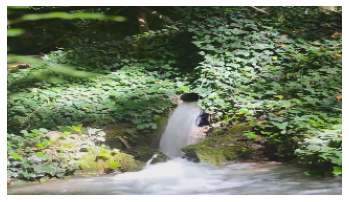

Target Vector Field


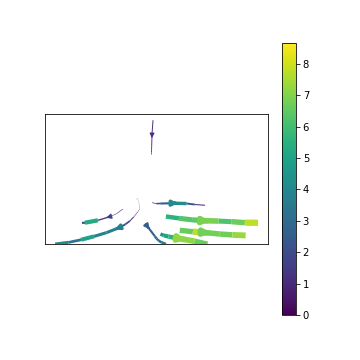

In [5]:
print("Target Appearance Image: ")
plt.imshow((target_appearance_img[0].detach().cpu().permute(1,2,0).numpy() + 1.0) / 2.0)
plt.axis("off")
plt.show()
print("Target Vector Field")
target_flow_vector_field = plot_vec_field(DynamicTextureLoss.loss_mapper["vector_field_motion"].target_motion_vec[0].detach().cpu().numpy(), name='Target')
target_flow_vector_field

# Create output folder

In [6]:
'''Create the log folder'''
img_name = args.target_appearance_path.split('/')[-1].split('.')[0]
print(f"Target Appearance: {img_name}")

output_dir = f'{args.output_dir}/{img_name}/{args.motion_vector_field_name}/'
"""
Note that this part might encounter permission issue, depending on your system and setting.
Call sudo if necessary. 
"""
if not args.video_only:
    try:
        os.system(f"mkdir -p {output_dir}")
        os.system(f"rm -rf {output_dir}/*")
    except:
        pass

Target Appearance: 01007_00000_input


# Initialize DyNCA, including model and pool.

In [7]:
nca_min_steps, nca_max_steps = args.nca_step_range

nca_model = DyNCA(c_in=args.nca_c_in, c_out=3, mask = args.nca_mask, fc_dim=args.nca_fc_dim,
                  seed_mode=args.nca_seed_mode,
                  pos_emb=args.nca_pos_emb, padding_mode=args.nca_padding_mode,
                  perception_scales=nca_perception_scales,
                  device=DEVICE)
with torch.no_grad():
    nca_pool = nca_model.seed(args.nca_pool_size, size=(nca_size_x, nca_size_y))

param_n = sum(p.numel() for p in nca_model.parameters())
print('DyNCA param count:', param_n)

optimizer = torch.optim.Adam(nca_model.parameters(), lr=args.lr)


args_log = copy.deepcopy(args.__dict__)
del args_log['DEVICE']
if 'target_motion_vec' in args_log:
    del args_log['target_motion_vec']

#with open(f'{output_dir}/args.txt', 'w') as f:
#    json.dump(args_log, f, indent=2)

if not args.video_only:
    pbar = tqdm(range(args.max_iterations), ncols=256)
else:
    pbar = tqdm(range(0))

if len(args.lr_decay_step) == 0:
    args.lr_decay_step = [[1000, 2000]]

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    args.lr_decay_step[0],
                                                    0.5)

input_dict = {}  # input dictionary for computing the loss functions
input_dict['target_image_list'] = [target_appearance_img]  # 0,1
input_dict['target_text'] = "black and white checkerboard"

interval = args.motion_weight_change_interval

loss_log_dict = defaultdict(list)
new_size = (nca_size_x, nca_size_y)


  0%|                                                                                                                                                                                                                                  | 0/4000 [00:00<?, ?it/s]

DyNCA param count: 6060


# Training code

In [8]:
for i in pbar:
    np.random.seed(i + 424)
    torch.manual_seed(i + 424)
    torch.cuda.manual_seed_all(i + 424)
    with torch.no_grad():
        batch_idx = np.random.choice(args.nca_pool_size, args.batch_size, replace=False)
        input_states = nca_pool[batch_idx]
        seed_injection = False
        if i % args.nca_inject_seed_step == 0:
            seed_injection = True
            seed_inject = nca_model.seed(1, size=(nca_size_x, nca_size_y))
            input_states[:1] = seed_inject[:1]

        '''Get the image before NCA iteration for computing optic flow'''

        nca_states_before, nca_features_before = nca_model.forward_nsteps(input_states, step_n=1)
        z_before_nca = nca_features_before
        image_before_nca = z_before_nca

    step_n = np.random.randint(nca_min_steps, nca_max_steps)
    input_dict['step_n'] = step_n
    nca_states_after, nca_features_after = nca_model.forward_nsteps(input_states, step_n)
    
    z = nca_features_after
    generated_image = z
    with torch.no_grad():
        generated_image_vis = generated_image.clone()
        generated_image_vis = (generated_image_vis + 1.0) / 2.0

    image_after_nca = generated_image.clone()

    '''Construct input dictionary for loss computation'''
    input_dict['generated_image_list'] = [generated_image]
    input_dict['generated_image_before_nca'] = image_before_nca
    input_dict['generated_image_after_nca'] = image_after_nca

    input_dict['nca_state'] = nca_states_after

    if (i + 1) % args.save_every == 0:
        batch_loss, batch_loss_log_dict, summary = DynamicTextureLoss(input_dict, return_summary=True)
    else:
        batch_loss, batch_loss_log_dict, _ = DynamicTextureLoss(input_dict, return_summary=False)
        summary = {}

    for loss_name in batch_loss_log_dict:
        loss_log_dict[loss_name].append(batch_loss_log_dict[loss_name])

    if i % interval == 0 and i > 0:
        print("Updating the motion loss weight")
        DynamicTextureLoss.set_loss_weight(loss_log_dict["appearance"], "vector_field_motion")

    with torch.no_grad():
        batch_loss.backward()
        if torch.isnan(batch_loss):
            with open(f'{output_dir}/train_failed.txt', 'w') as f:
                f.write(f'Epochs {i}')
            print('Loss is NaN. Train Failed. Exit.')
            exit()

        for p_name, p in nca_model.named_parameters():
            p.grad /= (p.grad.norm() + 1e-8)  # normalize gradients
            
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()

        nca_pool[batch_idx] = nca_states_after
        
        if i % 5 == 0:
            display_dict = copy.deepcopy(batch_loss_log_dict)
            display_dict['lr'] = lr_scheduler.get_lr()[0]
            pbar.set_postfix(display_dict)
        
        if (i + 1) % args.save_every == 0:
            clear_output(True)
            if 'vector_field_motion-generated_video_flow' in summary:
                generated_flow_vis = summary['vector_field_motion-generated_video_flow'] / 255.0
                gen_flow_show = save_train_image(generated_flow_vis[:4], f"{output_dir}/flow_gen{i}.jpg", return_img = True)

            if 'vector_field_motion-generated_flow_vector_field' in summary:
                generated_flow_vector_field = summary['vector_field_motion-generated_flow_vector_field']
                # generated_flow_vector_field.save(f"{output_dir}/vec_field_gen{i}.png")

            if 'vector_field_motion-target_flow_vector_field' in summary:
                target_flow_vector_field = summary['vector_field_motion-target_flow_vector_field']
                # target_flow_vector_field.save(f"{output_dir}/vec_field_target.png")

            img_show = save_train_image(generated_image_vis.detach().cpu().numpy(), f"{output_dir}/step{i}.jpg", return_img = True)

            '''Dict: loss log, yscale to log (True/False), ylim (True/False)'''
            plot_log_dict = {}
            plot_log_dict['Overflow Loss'] = (loss_log_dict['overflow'], True, True)
            num_plots = 1
            if "appearance" in loss_log_dict:
                num_plots += 1
                plot_log_dict['Texture Loss'] = (loss_log_dict['appearance'], True, True)

            # plot_train_log(plot_log_dict, num_plots, save_path=f"{output_dir}/losses.jpg")

            if "vector_field_motion" in loss_log_dict:
                plot_log_dict = {}
                plot_log_dict['Motion Loss'] = (
                    loss_log_dict['vector_field_motion'], False, False)
                plot_log_dict['Motion Direction Loss'] = (
                    loss_log_dict['vector_field_motion-direction'], False, False)
                plot_log_dict['Motion Strength Loss'] = (
                    loss_log_dict['vector_field_motion-strength'], False, False)
                # plot_train_log(plot_log_dict, 5, save_path=f"{output_dir}/losses_motion.jpg")
            
            plt.figure(figsize = (30, 30))
            
            plt.subplot(3,3,1)
            plt.title("Overflow Loss", fontsize = 20)
            plt.plot(loss_log_dict['overflow'], '.', alpha = 0.5)
            plt.yscale('log')
            
            plt.subplot(3,3,2)
            plt.title("Appearance Loss", fontsize = 20)
            plt.plot(loss_log_dict['appearance'], '.',alpha = 0.5)
            
            plt.subplot(3,3,3)
            plt.title("Motion Dynamic Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion'], '.', alpha = 0.5)
            
            plt.subplot(3,3,4)
            plt.title("Motion Direction Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion-direction_loss'], '.', alpha = 0.5)
            
            plt.subplot(3,3,5)
            plt.title("Motion Strength Loss", fontsize = 20)
            plt.plot(loss_log_dict['vector_field_motion-strength_diff'], '.', alpha = 0.5)
            
            plt.subplot(3,3,6)
            plt.title("Generated Image", fontsize = 20)
            plt.imshow(img_show)
            
            plt.subplot(3,3,7)
            plt.title("Generated Optic Flow", fontsize = 20)
            plt.imshow(gen_flow_show)
            
            plt.subplot(3,3,8)
            plt.axis("off")
            plt.imshow(generated_flow_vector_field)
            
            plt.subplot(3,3,9)
            plt.axis("off")
            plt.imshow(target_flow_vector_field)
            
            plt.show()
        

if not args.video_only:
    torch.save(nca_model, f"{output_dir}/model.pth")
else:
    layered_nca = torch.load(f"{output_dir}/model.pth")

  0%|                                                                                                                                                                                                                                  | 0/4000 [00:07<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 338.00 MiB (GPU 0; 10.00 GiB total capacity; 9.00 GiB already allocated; 0 bytes free; 9.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Generate Video

In [ ]:
def save_video(video_name, video_length, size_factor=1.0, step_n=8):
    fps = 30
    with VideoWriter(filename=f"{output_dir}/{video_name}.mp4", fps=fps, autoplay=True) as vid, torch.no_grad():
        h = nca_model.seed(1, size=(int(nca_size_x * size_factor), int(nca_size_y * size_factor)))
        for k in tqdm(range(int(video_length * fps)), desc="Making the video..."):
            nca_state, nca_feature = nca_model.forward_nsteps(h, step_n)

            z = nca_feature
            h = nca_state

            img = z.detach().cpu().numpy()[0]
            img = img.transpose(1, 2, 0)

            img = np.clip(img, -1.0, 1.0)
            img = (img + 1.0) / 2.0
            vid.add(img)
save_video("video", args.video_length, size_factor=1.0, step_n=int(args.nca_base_num_steps))

# Generate videos with large size WITHOUT re-training.

In [ ]:
save_video("video_large", args.video_length, size_factor=2.0, step_n=int(args.nca_base_num_steps))